# Computer Vision CSL7360 - Major Project

## Visual Odometry

### Vision-based odometry allows a vehicle to localize itself robustly by using only a stream of images captured by a camera attached to the vehicle. Idea behind visual odometry is to track distinctive features in consecutive images and use the displacement of these features to calculate the camera or robot's motion relative to its surroundings.

    Ayush Abrol B20AI052
    Devyani Gorkar B20ME027
    Anjali Agarwal B20AI051
    Aryan Tiwari B20AI056

---

## Necessary Imports

In [1]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import os
from os import listdir
from os.path import isfile, join

from IPython.display import display, Image
import time
import imageio

import warnings
warnings.filterwarnings('ignore')

import pickle
import io

## Defining Path 

In [2]:
poses = pd.read_csv('kitti/poses/00.txt', delimiter=' ', header=None)
ground_truth = np.zeros((len(poses), 3, 4))
for i in range(len(poses)):
    ground_truth[i] = np.array(poses.iloc[i]).reshape((3, 4))


In [3]:
left_img_files = os.listdir('kitti/00/image_0') 
img1_path = os.path.join('kitti/00/image_0', left_img_files[0])

# Load the image using OpenCV
img1 = cv2.imread(img1_path)

## Feature Detection

In [4]:
def SIFT_detector(img1, mask):
    gray_image = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) 

    sift = cv2.SIFT_create() 
    kp, des = sift.detectAndCompute(gray_image, mask) 
     
    return kp, des

def SURF_detector(img, mask):
    det = cv2.SURF_create()
    kp, des = det.detectAndCompute(img, mask)
    return kp, des

def ORB_detector(img, mask):
    gray_image = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) 
  
    orb = cv2.ORB_create(nfeatures=200) 
    kp, des = orb.detectAndCompute(gray_image, mask) 

    return kp, des


In [5]:
def feature_detector(image, detector_type='sift',mask=None):
    if detector_type == 'sift':
        kp, des = SIFT_detector(image, mask)
    if detector_type == 'orb':
        kp, des = ORB_detector(image, mask)
    if detector_type == 'surf':
        kp, des = SURF_detector(image, mask)
    return kp, des

## Utility functions

In [113]:
def plot(trajectory, ground_truth):       
        fig = plt.figure(figsize=(12,8))
        ax = fig.add_subplot(111)

        ax.plot(trajectory[:, 0, 3], 
        trajectory[:, 2, 3], label='estimated', color='green')
        ax.plot(ground_truth[:,0,3], ground_truth[:,2,3], label='ground_truth')

        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.legend()

In [7]:
def calculate_error(estimated, ground_truth):
    estimated = np.array(estimated)
    nframes_est = estimated.shape[0]-1
    se = np.sqrt((ground_truth[nframes_est, 0, 3] - estimated[:, 0, 3])**2 
                    + (ground_truth[nframes_est, 1, 3] - estimated[:, 1, 3])**2 
                    + (ground_truth[nframes_est, 2, 3] - estimated[:, 2, 3])**2)**2
    mse = se.mean()
    return mse

## Mono Viusal Odometry

In [39]:
class MonoVisualOdometry():
    def __init__(self, data_dir,K, P):
        self.K= K
        self.P = P
        self.data_dir = data_dir
        # self.gt_poses = self._load_poses(os.path.join(data_dir,"poses.txt"))
        self.images = os.listdir(data_dir)
        self.orb = cv2.ORB_create(3000)
        FLANN_INDEX_LSH = 6
        index_params = dict(algorithm=FLANN_INDEX_LSH, table_number=6, key_size=12, multi_probe_level=1)
        search_params = dict(checks=50)
        self.flann = cv2.FlannBasedMatcher(indexParams=index_params, searchParams=search_params)
        self.trajectory_points = []
        self.detected_features = []

    @staticmethod
    def _form_transf(R, t):
        T = np.eye(4, dtype=np.float64)
        T[:3, :3] = R
        T[:3, 3] = t
        return T

    def get_matches(self, i):
   
        img1_path = os.path.join(self.data_dir, self.images[i-1])
        img1 = cv2.imread(img1_path,0)
        img2_path = os.path.join(self.data_dir, self.images[i])
        img2 = cv2.imread(img2_path,0)
        # Find the keypoints and descriptors with ORB
        kp1, des1 = self.orb.detectAndCompute(img1, None)
        kp2, des2 = self.orb.detectAndCompute(img2, None)
        # Find matches
        matches = self.flann.knnMatch(des1, des2, k=2)

        # Find the matches there do not have a to high distance
        good = []
        try:
            for m, n in matches:
                if m.distance < 0.5 * n.distance:
                    good.append(m)
        except ValueError:
            pass

        draw_params = dict(matchColor = -1, # draw matches in green color
                 singlePointColor = None,
                 matchesMask = None, # draw only inliers
                 flags = 2)

        img3 = cv2.drawMatches(img2, kp1, img1,kp2, good ,None,**draw_params)
        # plt.imshow(cv2.cvtColor(img3, cv2.COLOR_BGR2RGB))
        # save_path = os.path.join("outputs/matches_image_0", f"matches_{i}.png")
        # plt.savefig(save_path)
        print(f"Match Number{i}")

        # Get the image points form the good matches
        q1 = np.float32([kp1[m.queryIdx].pt for m in good])
        q2 = np.float32([kp2[m.trainIdx].pt for m in good])
        self.detected_features.append((img2, q1, q2))
        return q1, q2

    def get_pose(self, q1, q2):
   
        # Essential matrix
        E, _ = cv2.findEssentialMat(q1, q2, self.K, threshold=1)

        # Decompose the Essential matrix into R and t
        R, t = self.decomp_essential_mat(E, q1, q2)

        # Get transformation matrix
        transformation_matrix = self._form_transf(R, np.squeeze(t))
        return transformation_matrix

    def decomp_essential_mat(self, E, q1, q2):
      
        def sum_z_cal_relative_scale(R, t):
            T = self._form_transf(R, t)
            P = np.matmul(np.concatenate((self.K, np.zeros((3, 1))), axis=1), T)

            hom_Q1 = cv2.triangulatePoints(self.P, P, q1.T, q2.T)
            hom_Q2 = np.matmul(T, hom_Q1)

            uhom_Q1 = hom_Q1[:3, :] / hom_Q1[3, :]
            uhom_Q2 = hom_Q2[:3, :] / hom_Q2[3, :]

            sum_of_pos_z_Q1 = sum(uhom_Q1[2, :] > 0)
            sum_of_pos_z_Q2 = sum(uhom_Q2[2, :] > 0)


            relative_scale = np.mean(np.linalg.norm(uhom_Q1.T[:-1] - uhom_Q1.T[1:], axis=-1)/
                                     np.linalg.norm(uhom_Q2.T[:-1] - uhom_Q2.T[1:], axis=-1))
            return sum_of_pos_z_Q1 + sum_of_pos_z_Q2, relative_scale

      
        R1, R2, t = cv2.decomposeEssentialMat(E)
        t = np.squeeze(t) 

        # Make a list of the different possible pairs
        pairs = [[R1, t], [R1, -t], [R2, t], [R2, -t]]

        # Check which solution there is the right one
        z_sums = []
        relative_scales = []
        for R, t in pairs:
            z_sum, scale = sum_z_cal_relative_scale(R, t)
            z_sums.append(z_sum)
            relative_scales.append(scale)

        # Select the pair there has the most points with positive z coordinate
        right_pair_idx = np.argmax(z_sums)
        right_pair = pairs[right_pair_idx]
        relative_scale = relative_scales[right_pair_idx]
        R1, t = right_pair
        t = t * relative_scale

        return [R1, t]
    
    def process(self):
        gt_path = []
        kitti_path = []
        for i in range(len(self.images)):
            if i == 0:
                cur_pose = np.eye(4)
            else:
                q1, q2 = self.get_matches(i)
                transf = self.get_pose(q1, q2)
                cur_pose = np.matmul(cur_pose, np.linalg.inv(transf))
                self.trajectory_points.append((cur_pose[0, 3], cur_pose[2, 3]))

            gt_path.append(cur_pose[:3, :])

        return gt_path, self.trajectory_points

    def save_trajectory_gif(self):
        gif_images = []
        for i, img_name in enumerate(self.images):
            img = cv2.imread(os.path.join(self.data_dir, img_name))
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            plt.plot(*zip(*self.trajectory_points[:i]), marker='o', color='r', linestyle='-')
            plt.axis('off')
            plt.title(f'Trajectory with {i} frames')
            plt.savefig('outputs/temp.png')
            plt.close()
            gif_images.append(imageio.imread('outputs/temp.png'))
        imageio.mimsave('outputs/trajectory.gif', gif_images)

## Left Camera Intrinsic Parameters

In [9]:
with open('kitti/00/calib.txt', 'r') as file:
    lines = file.readlines()

for line in lines:
    if line.startswith('P0:'):
        values = line.split(':')[1].strip().split()
        P0 = np.array([float(value) for value in values]).reshape(3, 4)
        break

print("P0:", P0)

P0: [[718.856    0.     607.1928   0.    ]
 [  0.     718.856  185.2157   0.    ]
 [  0.       0.       1.       0.    ]]


In [10]:
k_int = np.array([[718.856, 0.   , 607.1928],
                  [0.   , 718.856, 185.2157],
                  [0.    , 0.     , 1.    ]])

P = np.array([[718.85, 0.0, 607.19, 0], 
              [0.0, 718.85, 185.21, 0],
              [0.0, 0.0, 1.0, 0]])


## Frame Visualization

In [11]:
kitti_data_dir = 'kitti'
img_files = os.listdir('kitti/00/image_0')
img1_path = os.path.join('kitti/00/image_0', img_files[0])
img2_path = os.path.join('kitti/00/image_0', img_files[1])
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)

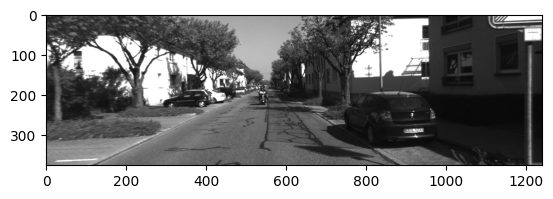

In [12]:
plt.imshow(img1)

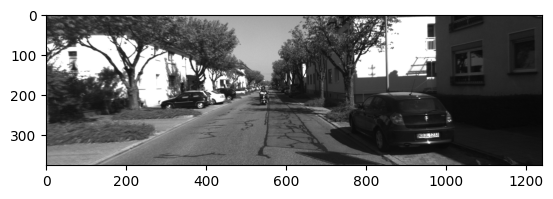

In [13]:
plt.imshow(img2)

In [111]:
folder_path = "kitti/00/image_0"

image_files = sorted([os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.endswith(('.jpg', '.jpeg', '.png'))])
num_images = min(100, len(image_files))

images = []
for i in range(num_images):
    image = imageio.imread(image_files[i])
    images.append(image)
gif_path = "outputs/kitti_output.gif"

imageio.mimsave(gif_path, images)

## Instantiate Mono Visual Odometry using Left camera

In [40]:
kitti_data_dir = 'kitti/00/image_0'
kitti_vo = MonoVisualOdometry(kitti_data_dir, k_int, P)
gt_path, trajectory_points = kitti_vo.process()

Match Number1
Match Number2
Match Number3
Match Number4
Match Number5
Match Number6
Match Number7
Match Number8
Match Number9
Match Number10
Match Number11
Match Number12
Match Number13
Match Number14
Match Number15
Match Number16
Match Number17
Match Number18
Match Number19
Match Number20
Match Number21
Match Number22
Match Number23
Match Number24
Match Number25
Match Number26
Match Number27
Match Number28
Match Number29
Match Number30
Match Number31
Match Number32
Match Number33
Match Number34
Match Number35
Match Number36
Match Number37
Match Number38
Match Number39
Match Number40
Match Number41
Match Number42
Match Number43
Match Number44
Match Number45
Match Number46
Match Number47
Match Number48
Match Number49
Match Number50
Match Number51
Match Number52
Match Number53
Match Number54
Match Number55
Match Number56
Match Number57
Match Number58
Match Number59
Match Number60
Match Number61
Match Number62
Match Number63
Match Number64
Match Number65
Match Number66
Match Number67
Matc

In [ ]:
kitti_vo.save_trajectory_gif()

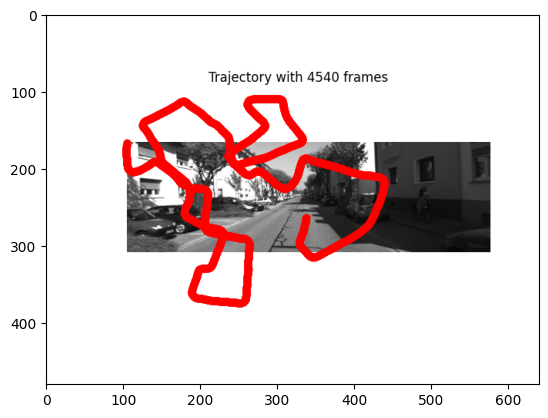

In [77]:
trajectory_ = cv2.imread('outputs/temp.png')
plt.imshow(cv2.cvtColor(trajectory_, cv2.COLOR_BGR2RGB))

In [41]:
with open('outputs/gt_path.pkl', 'wb') as f:
    pickle.dump(gt_path, f)

with open('outputs/trajctory_points.pkl', 'wb') as f:
    pickle.dump(trajectory_points, f)

In [ ]:
with open('outputs/gt_path.pkl', 'rb') as f:
    gt_path = pickle.load(f)

with open('outputs/trajectory_points.pkl', 'rb') as f:
    trajectory_points = pickle.load(f)

In [36]:
def plot_ground_truth_trajectory_no_img(poses_file_path):
    poses = pd.read_csv(poses_file_path, delimiter=' ', header=None)
    ground_truth = np.zeros((len(poses), 3, 4))
    for i in range(len(poses)):
        ground_truth[i] = np.array(poses.iloc[i]).reshape((3, 4))

    gif_frames = []
    for i in range(len(ground_truth)):
        x = ground_truth[i, 0, 3]
        z = ground_truth[i, 2, 3]
        # img = cv2.imread('kitti/00/image_0/' + str(i).zfill(6) + '.png')
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.plot(x, z, 'ro')

        plt.title(f'Trajectory with {i} frames')
        # plt.axis('off')

        plt.savefig('outputs/temp_gt_no_img.png')
        # plt.close()
        gif_frames.append(imageio.imread('outputs/temp_gt_no_img.png'))
    imageio.mimsave('outputs/trajectory_gt_no_img.gif', gif_frames)

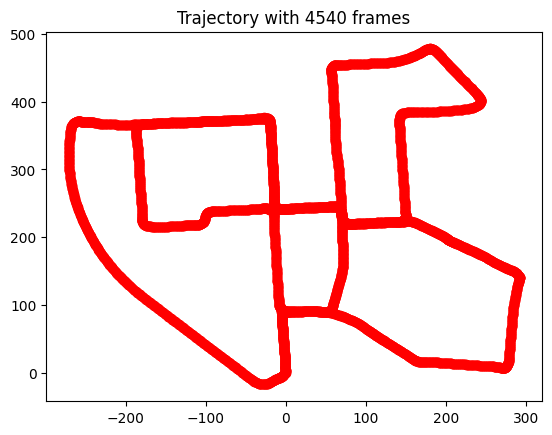

In [37]:
plot_ground_truth_trajectory_no_img('kitti/poses/00.txt')

In [75]:
def plot_compare_updated(poses_file_path):
    poses = pd.read_csv(poses_file_path, delimiter=' ', header=None)
    ground_truth = np.zeros((len(poses), 3, 4))
    for i in range(len(poses)):
        ground_truth[i] = np.array(poses.iloc[i]).reshape((3, 4))

    gif_frames = []
    for i in range(len(ground_truth)):
        x = ground_truth[:i, 0, 3]
        z = ground_truth[:i, 2, 3]
        # img = cv2.imread('kitti/00/image_0/' + str(i).zfill(6) + '.png')
        # plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.plot(x, z, color='r', marker = '*',linestyle = '-', label='Ground Truth')
        plt.plot(*zip(*trajectory_points[:i]), color='b', marker ='o', linestyle='-', label='Estimated Trajectory')

        plt.title(f'Trajectory with {i} frames')
        # plt.axis('off')

        plt.savefig('outputs/temp_compare_updated.png')
        plt.close()
        gif_frames.append(imageio.imread('outputs/temp_compare_updated.png'))
    imageio.mimsave('outputs/trajectory_compare_updated.gif', gif_frames)

In [76]:
plot_compare_updated('kitti/poses/00.txt')

In [78]:
def plot_complete(poses_file_path):
    poses = pd.read_csv(poses_file_path, delimiter=' ', header=None)
    ground_truth = np.zeros((len(poses), 3, 4))
    for i in range(len(poses)):
        ground_truth[i] = np.array(poses.iloc[i]).reshape((3, 4))

    gif_frames = []
    for i in range(len(ground_truth)):
        x = ground_truth[:i, 0, 3]
        z = ground_truth[:i, 2, 3]
        img = cv2.imread('kitti/00/image_0/' + str(i).zfill(6) + '.png')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.plot(x, z, color='r', marker = '*',linestyle = '-', label='Ground Truth')
        plt.plot(*zip(*trajectory_points[:i]), color='b', marker ='o', linestyle='-', label='Estimated Trajectory')

        plt.title(f'Trajectory with {i} frames')
        # plt.axis('off')

        plt.savefig('outputs/full_plot.png')
        plt.close()
        gif_frames.append(imageio.imread('outputs/full_plot.png'))
    imageio.mimsave('outputs/full_plot.gif', gif_frames)

In [79]:
plot_complete('kitti/poses/00.txt')

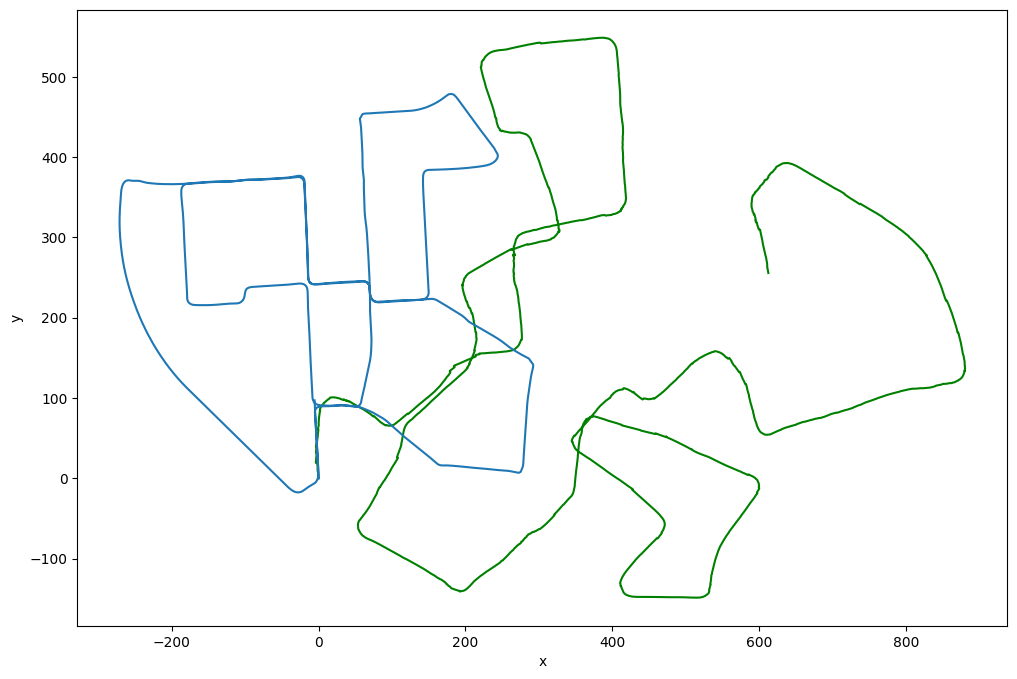

In [80]:
plot(np.array(gt_path), ground_truth)

In [81]:
print("Error for MonoVisualOdometry:", calculate_error(gt_path, ground_truth))

Error for MonoVisualOdometry: 254227.00112599428


## Feature tracking Visual Odometery

In [82]:
def normalize_points(points, K_inv):
    # Normalize image points to get normalized image coordinates
    homogeneous_points = np.concatenate([points, np.ones((points.shape[0], 1))], axis=1)
    return np.dot(homogeneous_points, K_inv.T)

def essential_matrix(kp1, kp2, K):
    K_inv = np.linalg.inv(K)
    
    # Normalize keypoints
    norm_kp1 = normalize_points(kp1, K_inv)
    norm_kp2 = normalize_points(kp2, K_inv)
    
    A = np.array([
        [u1*u2, v1*u2, u2, u1*v2, v1*v2, v2, u1, v1, 1]
        for (u1, v1), (u2, v2) in zip(norm_kp1, norm_kp2)
    ])
    
    _, _, V = np.linalg.svd(A)
    F_flat = V[-1]
    F = F_flat.reshape(3, 3)
    
    U, S, Vt = np.linalg.svd(F)
    S[-1] = 0
    F = np.dot(U, np.dot(np.diag(S), Vt))
    
    E = np.dot(K.T, np.dot(F, K))
    
    return E


In [85]:
class VisualOdometryTracking():
    def __init__(self,kmin):
        self.kMinNumFeature = kmin
        self.traj = np.zeros((600, 600, 3), dtype=np.uint8)
        self.x_loc = []
        self.z_loc = []
        self.cur_R = None
        self.cur_t = None
        self.trajectory = None
        self.trajectory_points = []

    def convert_to_homogeneous_matrix(self, rmat, tvec):
        T_mat = np.eye(4, 4)
        T_mat[:3, :3] = rmat
        T_mat[:3, 3] = tvec.T
        return T_mat

    def featureTracking(self, image_ref, image_cur, px_ref):
        lk_params = dict(winSize=(21, 21),
                         criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 30, 0.01))
        kp2, st, err = cv2.calcOpticalFlowPyrLK(image_ref, image_cur, px_ref, None, **lk_params)
        st = st.reshape(st.shape[0])
        kp1 = px_ref[st == 1]
        kp2 = kp2[st == 1]
        return kp1, kp2

    def process_first_frames(self, first_frame, second_frame, k):
        det = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
        kp1 = det.detect(first_frame)
        kp1 = np.array([x.pt for x in kp1], dtype=np.float32)

        kp1, kp2 = self.featureTracking(first_frame, second_frame, kp1)
        E, mask = cv2.findEssentialMat(kp2, kp1, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
        _, R, t, mask = cv2.recoverPose(E, kp2, kp1, k)
        kp1 = kp2
        return kp1, R, t

    def feature_tracking_vo_pipeline(self,data_dir, left_img_files, initial, k):
        first_frame_path = os.path.join(data_dir, left_img_files[initial])
        first_frame = cv2.imread(first_frame_path, 0)
        second_frame_path = os.path.join(data_dir, left_img_files[initial + 1])
        second_frame = cv2.imread(second_frame_path, 0)
        kp1, self.cur_R, self.cur_t = self.process_first_frames(first_frame, second_frame, k)
        last_frame = second_frame
        self.trajectory = np.zeros((len(left_img_files), 3, 4))
        T = np.eye(4)
        self.trajectory[0] = T[:3, :]

        for i in range(len(left_img_files) - 1):
            print(f"Match Number {i}")
            new_img_path = os.path.join(data_dir, left_img_files[i])
            new_frame = cv2.imread(new_img_path, 0)
            kp1, kp2 = self.featureTracking(last_frame, new_frame, kp1)
            E, mask = cv2.findEssentialMat(kp2, kp1, k, method=cv2.RANSAC, prob=0.999, threshold=1.0)
            _, R, t, mask = cv2.recoverPose(E, kp2, kp1, k)

            change = np.mean(np.abs(kp2 - kp1))

            if change > 5:
                self.cur_t = self.cur_t + 1 * self.cur_R.dot(t)
                self.cur_R = R.dot(self.cur_R)
            if kp1.shape[0] < self.kMinNumFeature:
                det = cv2.FastFeatureDetector_create(threshold=20, nonmaxSuppression=True)
                kp2 = det.detect(new_frame)
                kp2 = np.array([x.pt for x in kp2], dtype=np.float32)

            kp1 = kp2

            last_frame = new_frame
            if i > 2:
                tvec = np.array([self.cur_t[0], self.cur_t[1], self.cur_t[2]]).reshape(3, 1)
            else:
                tvec = np.array([0, 0, 0]).reshape(3, 1)

            T_mat = self.convert_to_homogeneous_matrix(self.cur_R, self.cur_t)

            self.trajectory[i + 1, :, :] = T_mat[:3, :]

        return self.trajectory
    
    def save_trajectory_gif(self, ground_truth):
        gif_images = []
        for i in range(len(self.trajectory)):
            # Plot trajectory
            img = cv2.imread('kitti/00/image_0/' + str(i).zfill(6) + '.png')
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
            x = self.trajectory[:i, 0, 3]
            z = self.trajectory[:i, 2, 3]
            plt.plot(x, z, color='red', marker='o', linestyle='-', label='trajectory')
            x1 = ground_truth[:i, 0, 3]
            z1 = ground_truth[:i, 2, 3]
            plt.plot(x1, z1, color='blue', marker='o', linestyle='-', label='ground truth')

            # Title and labels
            plt.title(f'Trajectory for frame {i}')

            # Save current frame as image buffer
            plt.savefig('outputs/feature_tracking/temp.png')
            plt.close()
            # Append frame to list  
            gif_images.append(imageio.imread('outputs/feature_tracking/temp.png'))

        # Save frames as GIF
        imageio.mimsave('outputs/feature_tracking/trajectory.gif', gif_images)

In [86]:
data_dir = 'kitti/00/image_0'

vo = VisualOdometryTracking(kmin= 1000)
left_img_files = os.listdir(data_dir)
trajectory = vo.feature_tracking_vo_pipeline(data_dir, left_img_files, 0, k_int)

Match Number 0
Match Number 1
Match Number 2
Match Number 3
Match Number 4
Match Number 5


Match Number 6
Match Number 7
Match Number 8
Match Number 9
Match Number 10
Match Number 11
Match Number 12
Match Number 13
Match Number 14
Match Number 15
Match Number 16
Match Number 17
Match Number 18
Match Number 19
Match Number 20
Match Number 21
Match Number 22
Match Number 23
Match Number 24
Match Number 25
Match Number 26
Match Number 27
Match Number 28
Match Number 29
Match Number 30
Match Number 31
Match Number 32
Match Number 33
Match Number 34
Match Number 35
Match Number 36
Match Number 37
Match Number 38
Match Number 39
Match Number 40
Match Number 41
Match Number 42
Match Number 43
Match Number 44
Match Number 45
Match Number 46
Match Number 47
Match Number 48
Match Number 49
Match Number 50
Match Number 51
Match Number 52
Match Number 53
Match Number 54
Match Number 55
Match Number 56
Match Number 57
Match Number 58
Match Number 59
Match Number 60
Match Number 61
Match Number 62
Match Number 63
Match Number 64
Match Number 65
Match Number 66
Match Number 67
Match Number

In [88]:
with open('outputs/feature_tracking/trajectory.pkl', 'wb') as f:
    pickle.dump(trajectory, f)

In [90]:
vo.save_trajectory_gif(ground_truth)

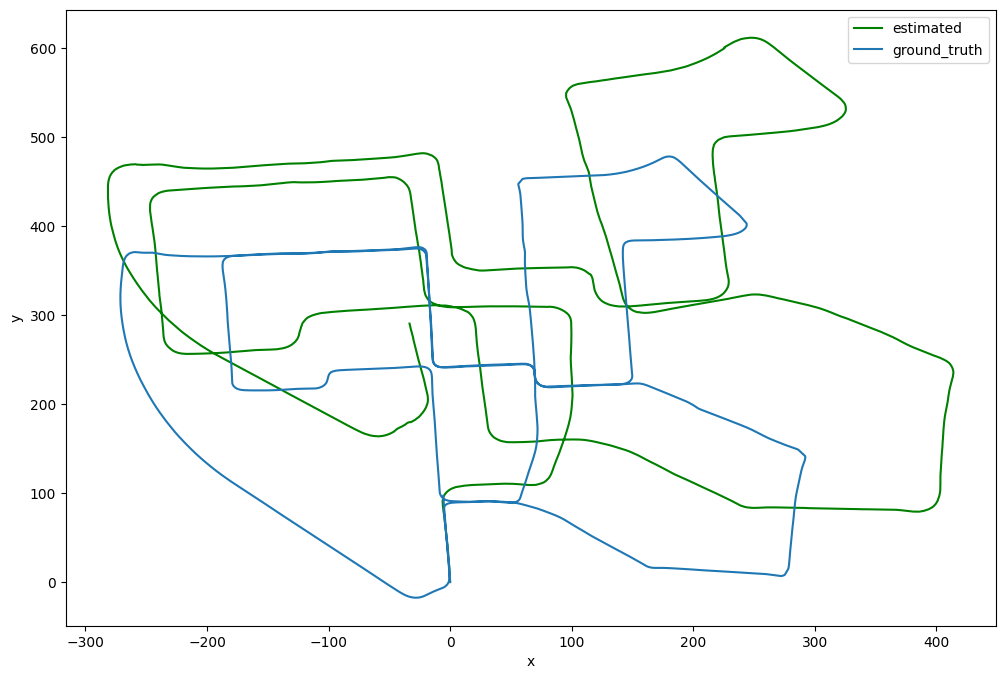

In [114]:
plot(trajectory, ground_truth)

In [94]:
calculate_error(trajectory,ground_truth)

184299.7626976141

## Stereo Visual Odometery

In [105]:
def decompose_projection_matrix(p):
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    return k, r, t

def compute_depth_map(img_left, img_right, k_left, t_left, t_right, matcher_name='sgbm'):
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities, blockSize=block_size)
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(
            numDisparities=num_disparities,
            minDisparity=0,
            blockSize=block_size,
            P1=8 * 3 * sad_window ** 2,
            P2=32 * 3 * sad_window ** 2,
            mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
        )

    disp_left = matcher.compute(img_left, img_right).astype(np.float32) / 16
    
    f = k_left[0][0]

    b = t_right[0] - t_left[0]
    
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

def stereo_motion_est(match, kp1, kp2, k, depth1, max_depth=3000):
    rmat = np.eye(3)
    tvec = np.zeros((3, 1))
    
    image1_points = np.float32([kp1[m.queryIdx].pt for m in match])
    image2_points = np.float32([kp2[m.trainIdx].pt for m in match])

    cx = k[0, 2]
    cy = k[1, 2]
    fx = k[0, 0]
    fy = k[1, 1]
    object_points = np.zeros((0, 3))
    delete = []

    for i, (u, v) in enumerate(image1_points):
        z = depth1[int(v), int(u)]
        
        if z > max_depth:
            delete.append(i)
            continue
            
        x = z*(u-cx)/fx
        y = z*(v-cy)/fy
        object_points = np.vstack([object_points, np.array([x, y, z])])

    image1_points = np.delete(image1_points, delete, 0)
    image2_points = np.delete(image2_points, delete, 0)
    
    _, rvec, tvec, inliers = cv2.solvePnPRansac(object_points, image2_points, k, None)
    
    rmat = cv2.Rodrigues(rvec)[0]
    
    return rmat, tvec, image1_points, image2_points

def match_features(des1, des2, sort=True, k=2):
    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    matcher = cv2.FlannBasedMatcher(index_params, search_params)
    matches = matcher.knnMatch(des1, des2, k=k)

    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

def filter_matches(matches, dist_threshold):
    filtered_matches = []
    for m,n in matches:
        ratio = m.distance/n.distance
        if ratio <= dist_threshold:
            filtered_matches.append(m)
    return filtered_matches

def convert_to_homogeneous_matrix(rmat,tvec):
    T_mat = np.eye(4,4)
    T_mat[:3,:3] = rmat
    T_mat[:3,3] = tvec.T
    return T_mat

def stereo_vo_pipeline(left_img_files, right_img_files, P0, P1, matcher='FLANN'):
    num_frames = len(left_img_files)
    T_tot = np.eye(4)
    trajectory = np.zeros((num_frames, 3, 4))
    trajectory[0] = T_tot[:3, :]
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    SIFT_det = cv2.SIFT_create()

    for i in range(num_frames-1):
        print(f"Match Number {i}")
        img_left_path = os.path.join('kitti/00/image_0', left_img_files[i]) 
        img_left = cv2.imread(img_left_path)
        img_right_path = os.path.join('kitti/00/image_1', right_img_files[i])
        img_right = cv2.imread(img_right_path)
        next_img_left = cv2.imread(os.path.join('kitti/00/image_0', left_img_files[i+1]))
        
        depth = compute_depth_map(img_left, img_right, k_left, t_left, t_right)
        kp1, des1 = SIFT_det.detectAndCompute(img_left, None)
        kp2,des2 = SIFT_det.detectAndCompute(next_img_left, None)

        matches= match_features(des1, des2)
        filtered_matches = filter_matches(matches, dist_threshold=0.5 )

        R, t, img1_points, img2_points = stereo_motion_est(filtered_matches, kp1, kp2, k_left, depth1=depth)
        
        T_mat = convert_to_homogeneous_matrix(R, t)
        T_tot = T_tot.dot(np.linalg.inv(T_mat))

        trajectory[i+1, :, :] = T_tot[:3, :]
    return trajectory

def save_trajectory_gif(trajcetory, ground_truth):
    gif_images = []
    for i in range(len(trajectory)):
        # Plot trajectory
        img = cv2.imread('kitti/00/image_0/' + str(i).zfill(6) + '.png')
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        x = trajectory[:i, 0, 3]
        z = trajectory[:i, 2, 3]
        plt.plot(x, z, color='red', marker='o', linestyle='-', label='trajectory')
        x1 = ground_truth[:i, 0, 3]
        z1 = ground_truth[:i, 2, 3]
        plt.plot(x1, z1, color='blue', marker='o', linestyle='-', label='ground truth')

        # Title and labels
        plt.title(f'Trajectory for frame {i}')

        # Save current frame as image buffer
        plt.savefig('outputs/stereo/temp.png')
        plt.close()
        # Append frame to list  
        gif_images.append(imageio.imread('outputs/stereo/temp.png'))

    # Save frames as GIF
    imageio.mimsave('outputs/stereo/trajectory.gif', gif_images)

In [97]:
img_left_path = os.path.join('kitti/00/image_0', left_img_files[0])
img_left = cv2.imread(img_left_path, 0)
right_img_files =  os.listdir('kitti/00/image_1') 
img_right = os.path.join('kitti/00/image_1', right_img_files[0])
img_right = cv2.imread(img_right, 0)

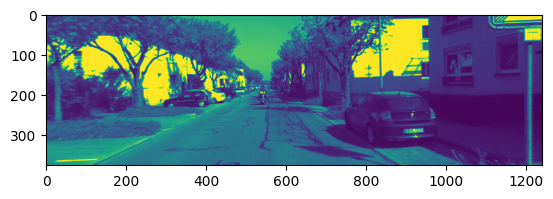

In [98]:
plt.imshow(img_left)

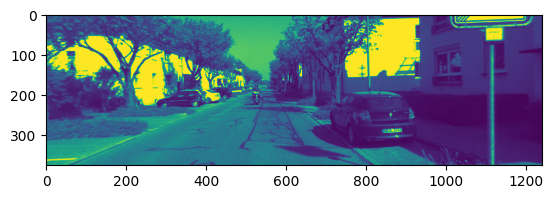

In [99]:
plt.imshow(img_right)

In [100]:
calib = pd.read_csv('kitti/' + 'calib.txt', delimiter=' ', header=None, index_col=0)
P0 = np.array(calib.loc['P0:']).reshape((3,4))
P1 = np.array(calib.loc['P1:']).reshape((3,4))
k_left, r_left, t_left = decompose_projection_matrix(P0)
k_right, r_right, t_right = decompose_projection_matrix(P1)

In [103]:
print("P0 =", P0, "\n")
print("P1 =", P1)

P0 = [[718.856    0.     607.1928   0.    ]
 [  0.     718.856  185.2157   0.    ]
 [  0.       0.       1.       0.    ]] 

P1 = [[ 718.856     0.      607.1928 -386.1448]
 [   0.      718.856   185.2157    0.    ]
 [   0.        0.        1.        0.    ]]


In [106]:
stereo_trajectory = stereo_vo_pipeline(left_img_files,right_img_files, P0, P1)

Match Number 0
Match Number 1
Match Number 2
Match Number 3
Match Number 4
Match Number 5
Match Number 6
Match Number 7
Match Number 8
Match Number 9
Match Number 10
Match Number 11
Match Number 12
Match Number 13
Match Number 14
Match Number 15
Match Number 16
Match Number 17
Match Number 18
Match Number 19
Match Number 20
Match Number 21
Match Number 22
Match Number 23
Match Number 24
Match Number 25
Match Number 26
Match Number 27
Match Number 28
Match Number 29
Match Number 30
Match Number 31
Match Number 32
Match Number 33
Match Number 34
Match Number 35
Match Number 36
Match Number 37
Match Number 38
Match Number 39
Match Number 40
Match Number 41
Match Number 42
Match Number 43
Match Number 44
Match Number 45
Match Number 46
Match Number 47
Match Number 48
Match Number 49
Match Number 50
Match Number 51
Match Number 52
Match Number 53
Match Number 54
Match Number 55
Match Number 56
Match Number 57
Match Number 58
Match Number 59
Match Number 60
Match Number 61
Match Number 62
Ma

In [107]:
save_trajectory_gif(stereo_trajectory, ground_truth)

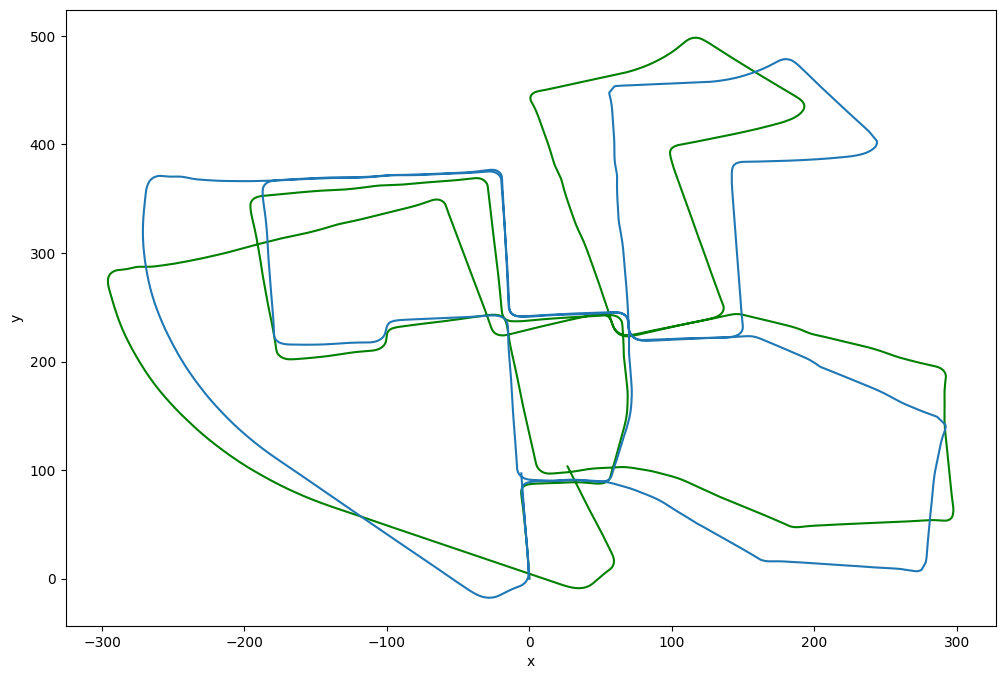

In [108]:
plot(stereo_trajectory,ground_truth)

In [115]:
calculate_error(stereo_trajectory,ground_truth)

53369.630670950115